In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
path_meta = './macho/MACHO/MACHO_dataset.dat'
path_light_Curves = './macho/MACHO/'


metadata = pd.read_csv(path_meta)
metadata = metadata[metadata.N>10]
metadata.head()

,Unnamed: 0,Class,N,Path,Band
0,0,RRL,1143,LCs/lc_1_3808_1671_B_mjd.dat,B
1,1,RRL,1135,LCs/lc_1_4167_1280_B_mjd.dat,B
2,2,RRL,1089,LCs/lc_2_5752_376_B_mjd.dat,B
3,3,RRL,1108,LCs/lc_2_5146_1297_B_mjd.dat,B
4,4,RRL,1021,LCs/lc_2_5873_895_B_mjd.dat,B


In [3]:
classes, amount = np.unique(metadata.Class, return_counts=True)

<BarContainer object of 7 artists>

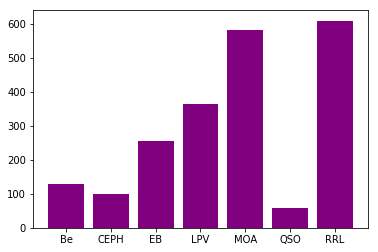

In [4]:
plt.bar(classes, amount, color='purple')

In [5]:
def plot_lc(mjd, mag, errmag, N, label):
    plt.clf()
    plt.title(label)
    plt.errorbar(mjd[:N], mag[:N], yerr=errmag[:N], color='k', ecolor='r')
    plt.grid(True)
    plt.show()

In [20]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


class MACHOLoader(object):
    def __init__(self, data, lenght):
        """ 
        Preprocessing the data for creating the dataloader
        """
        self.data = data
        self.lenght = lenght

    def __len__(self):
        """
        Number of images in the object dataset.
        """
        return self.data.shape[0]

    def __getitem__(self, index):
        """
        Return an item from the dataset.
        """
        x = np.zeros((3, self.lenght))
        light_curve = pd.read_csv(path_light_Curves + self.data.Path[index], skiprows=2, 
                                  delim_whitespace=False, names=['mjd', 'mag', 'errmag'])
        light_curve = light_curve.values.T
        light_curve = self.normalize(light_curve)
        x[:,:light_curve.shape[1]] = light_curve
        
        y = self.data.Class[index]
        return np.float32(x).T, np.int(y), light_curve.shape[1]
    
    def normalize(self, light_curve):
        """ 
        Normalizing the data feature by feature.
        """
        for i, feature in enumerate(light_curve):
            max_ = np.max(feature)
            min_ = np.min(feature)
            light_curve[i,:] = (light_curve[i,:] - min_) / (max_ - min_)
        return light_curve
        
        

def get_MACHO_loaders(metadata, batch_size, mode='train'):
    """Build and return data loader."""
    
    class_dict = {class_:i for i, class_ in enumerate(np.unique(metadata.Class))}
    metadata = metadata.replace({'Class': class_dict})
    
    
    lc_data_train, lc_data_test = train_test_split(metadata, test_size=0.5)
    data_train = MACHOLoader(lc_data_train.reset_index(), np.max(metadata.N))
    
    lc_data_val, lc_data_test = train_test_split(lc_data_test, test_size=0.4)
    data_val = MACHOLoader(lc_data_val.reset_index(), np.max(metadata.N))
    data_test = MACHOLoader(lc_data_test.reset_index(), np.max(metadata.N))
    
    class_sample_count = np.unique(lc_data_train.Class, return_counts=True)[1]
    weights = 1. / torch.Tensor(class_sample_count)
    samples_weight = np.array([weights[t] for t in lc_data_train.Class])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), 
                                                             len(samples_weight))
    data_loader_train = DataLoader(dataset=data_train,
                             batch_size=batch_size, sampler=sampler, drop_last=True)
        
    data_loader_val = DataLoader(dataset=data_val,
                                 batch_size=batch_size,
                                 shuffle=False, drop_last=True)
    
    data_loader_test = DataLoader(dataset=data_test,
                                  batch_size=batch_size,
                                  shuffle=False, drop_last=True)
    return data_loader_train, data_loader_val, data_loader_test, class_dict


In [70]:
batch_size = 64
dataloader_train, dataloader_val, dataloader_test, class_dict = get_MACHO_loaders(metadata, batch_size)
inv_class_dict = {i:class_ for i, class_ in enumerate(class_dict.keys())}
some_lcs = iter(dataloader_train).next()

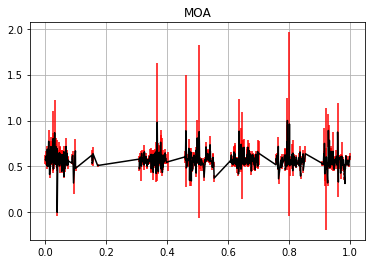

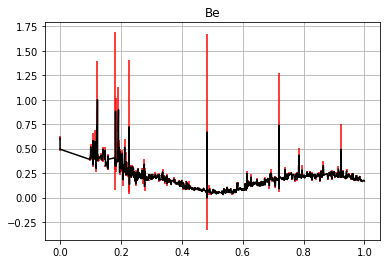

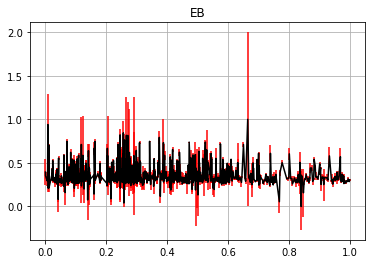

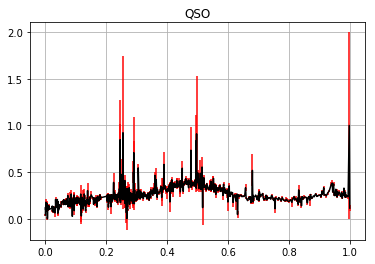

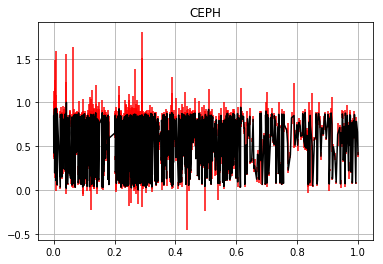

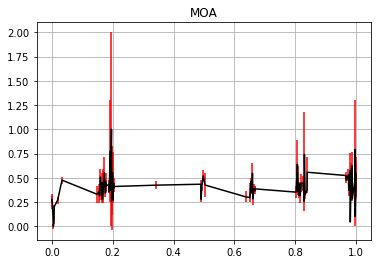

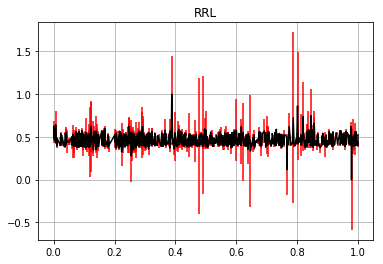

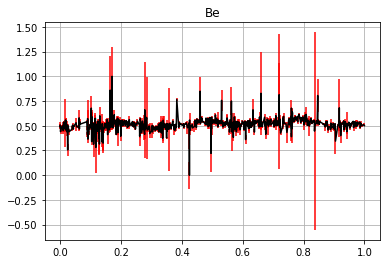

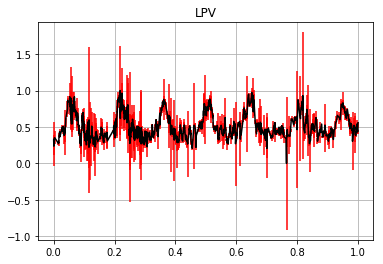

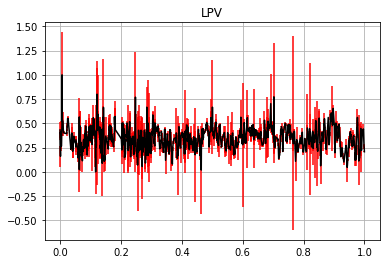

In [77]:
for i, lc in enumerate(some_lcs[0][:10]):
    label = inv_class_dict[some_lcs[1][i].item()]
    plot_lc(lc[:,0].numpy(), lc[:,1].numpy(), lc[:,2].numpy(), some_lcs[2][i], label)

In [83]:
import torch.nn as nn

class LightCurveNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(LightCurveNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.fc(lstm_out)
        out = self.softmax(out)
        out = out.view(batch_size, -1, 7)
        out = out[:,-1, :]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [84]:
class EarlyStopping:
    def __init__(self, patience):
        """Class for determining the stopping criterion for the model"""
        self.patience = patience
        self.counter = 0
        self.best_metric = 0

    def count(self, metric, model):
        is_best = bool( metric >= self.best_metric)
        self.best_metric = max(metric, self.best_metric)
        if is_best:
            self.counter = 0
            self.save_weights(model)
            print('Weights saved.')
        else:
            self.counter += 1
        if self.counter >= self.patience:
            return True
        else:
            return False

    def save_weights(self, model):
        """Save Autoencoder weights."""
        torch.save(model.state_dict(), 'weights/model_parameters.pth')

In [85]:
device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = 3
output_size = len(class_dict.keys())
hidden_dim = 256
n_layers = 2 
drop_prob = 0.5

In [86]:
model = LightCurveNet(input_size, output_size, hidden_dim, n_layers, drop_prob)
model.to(device)

lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
nb_epochs = 2000
patience = 25
es = EarlyStopping(patience)

In [87]:
from sklearn.metrics import f1_score


def test(model, dataloader, epoch, nb_epochs):
    model.eval()
    h = model.init_hidden(batch_size)
    total_loss=0
    total_f1=0
    with torch.no_grad():
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = tuple([each.data for each in h])
            out, val_h = model(inputs, h)
            val_loss = criterion(out, labels.long())
            total_loss+=val_loss.item()
            total_f1+=f1_score(labels.cpu().numpy(), 
                                      np.argmax(out.cpu().detach().numpy(), axis=1), average='macro')
            
    loss = total_loss/len(dataloader)
    f1 = total_f1/len(dataloader)
    print("Epoch: {}/{}...".format(epoch+1, nb_epochs),
          "Loss val: {:.3f}...".format(loss),
          "F1-score val: {:.3f}...".format(f1),
         )
    stop = es.count(f1, model)
    return stop, loss, f1   



for epoch in range(nb_epochs):
    model.train()
    h = model.init_hidden(batch_size)
    total_loss, total_loss_val = 0, 0
    total_f1, total_f1_val = 0, 0
    for inputs, labels, _ in dataloader_train:
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        h = tuple([e.data for e in h])
        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.long())
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        total_f1+=f1_score(labels.cpu().numpy(), np.argmax(output.cpu().detach().numpy(), axis=1), average='macro')
    
    print("Epoch: {}/{}...".format(epoch+1, nb_epochs),
          "Loss train: {:.3f}...".format(total_loss/len(dataloader_train)),
          "F1-score train: {:.3f}...".format(total_f1/len(dataloader_train)),
         )
    
    stop, loss_val, f1_val = test(model, dataloader_val, epoch, nb_epochs)
    if stop:
        break

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/2000... Loss train: 1.946... F1-score train: 0.036...
Epoch: 1/2000... Loss val: 1.929... F1-score val: 0.065...
Weights saved.
Epoch: 2/2000... Loss train: 1.947... F1-score train: 0.041...
Epoch: 2/2000... Loss val: 1.952... F1-score val: 0.016...
Epoch: 3/2000... Loss train: 1.946... F1-score train: 0.055...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 3/2000... Loss val: 1.946... F1-score val: 0.016...
Epoch: 4/2000... Loss train: 1.943... F1-score train: 0.067...
Epoch: 4/2000... Loss val: 1.865... F1-score val: 0.065...
Weights saved.
Epoch: 5/2000... Loss train: 1.952... F1-score train: 0.032...
Epoch: 5/2000... Loss val: 1.949... F1-score val: 0.038...
Epoch: 6/2000... Loss train: 1.947... F1-score train: 0.039...
Epoch: 6/2000... Loss val: 1.941... F1-score val: 0.021...
Epoch: 7/2000... Loss train: 1.946... F1-score train: 0.035...
Epoch: 7/2000... Loss val: 1.942... F1-score val: 0.021...
Epoch: 8/2000... Loss train: 1.945... F1-score train: 0.037...
Epoch: 8/2000... Loss val: 1.943... F1-score val: 0.021...
Epoch: 9/2000... Loss train: 1.947... F1-score train: 0.051...
Epoch: 9/2000... Loss val: 1.945... F1-score val: 0.038...
Epoch: 10/2000... Loss train: 1.946... F1-score train: 0.060...
Epoch: 10/2000... Loss val: 1.944... F1-score val: 0.038...
Epoch: 11/2000... Loss train: 1.946... F1-score train: 0.038...
Epoch: